In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import pickle

torch.set_default_dtype(torch.float64)

/home/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [3]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=3/10, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=2/3, random_state=42)

print("print some values for further reference:")
print("training:\n", X_train[:5])
print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

del X_train, Y_train, X_val_test, Y_val_test, X_val, Y_val

print some values for further reference:
training:
 tensor([[-1.6470, -0.4548],
        [-1.4219, -0.2572],
        [-1.1212, -0.3319],
        [-2.1724, -0.8192],
        [-2.2981, -0.4868]])
validation:
 tensor([[-2.3239, -0.7632],
        [-1.5700, -0.7814],
        [-2.5760, -0.7125],
        [-2.6962, -0.1298],
        [-2.4792, -0.9901]])
testing:
 tensor([[-1.8786, -0.7309],
        [-2.1238, -0.5445],
        [-1.5464, -0.0327],
        [-2.1123, -0.9096],
        [-2.3488, -0.4341]])


Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file training_logs/lightning_logs/version_final/checkpoints/epoch=9533-step=209748.ckpt`


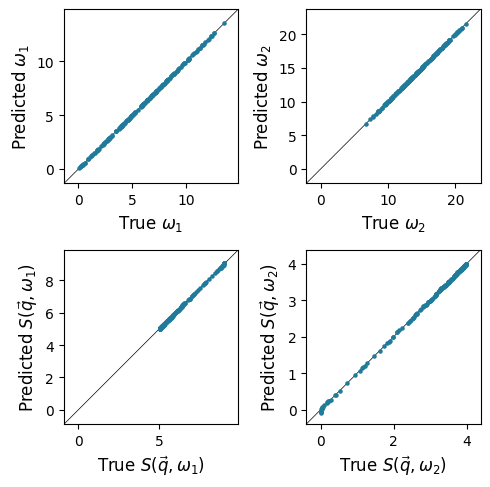

In [4]:
model_spec = SpectrumPredictor.load_from_checkpoint("training_logs/lightning_logs/version_final/checkpoints/epoch=9533-step=209748.ckpt")

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test).detach()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

In [5]:
import optbayesexpt as obe
from src.utils_model import construct_fc_net, array2tensor, tensor2array
from src.bayes import BayesianInference, jit_batch_spec_to_Sqt

In [6]:
times = np.arange(0,5,0.01)
settings = (times, )
parameters = (
    np.random.uniform(-3.0, 0.0, 1001),
    np.random.uniform(-1.0, 0.0, 1001),
    np.random.uniform( 0.0, 1.0, 1001)
    )
# parameters = (
#     np.random.uniform(-0.5, 0.0, 1001),
#     np.random.uniform(-0.5,-0.0, 1001),
#     np.random.uniform( 0.0, 1.0, 1001)
#     )

In [7]:
from numba import njit, prange

@njit
def interp_nb(t, tp, Sp):
    return np.interp(t, tp, Sp)

@njit
def get_I_conv_at_t(t, tp, Sp, pulse_width):
    t_around = np.linspace(t-pulse_width/2, t+pulse_width/2, int(pulse_width/0.01))
    I_out = np.trapz(np.abs(interp_nb(t_around, tp, Sp))**2, t_around) / pulse_width
    return I_out

@njit(parallel=True)
def get_I_conv(t, tp, Sp, pulse_width):
    if isinstance(t, (int, float)):
        t = np.asarray([t,])
    I_out = np.zeros_like(t)
    for i_t in prange(len(t)):
        I_out[i_t] = get_I_conv_at_t(t[i_t], tp, Sp, pulse_width)
    # I_0 = get_I_conv_at_t(func_S, 0., pulse_width)
    # I_out = I_out / I_0
    return I_out

In [8]:
def prepare_sample(idx, pulse_width=0.1, visualize=False, normalize_to_value=None):
    # prepare Sqt energies and intensities
    x_test = X_test[idx]
    y_test = Y_test[idx]
    gamma = 0.1
    noise_level = 10.0

    omega_test, inten_test = torch.split(y_test, y_test.shape[0]//2)
    true_pars = x_test.cpu().numpy().tolist() + [gamma,]

    # setup time for Sqt computation
    dt = times[1]-times[0]
    times_extended = np.arange(times[0]-pulse_width, times[-1]+pulse_width, dt)
    times_extended_tensor = torch.from_numpy(times_extended)

    # S and |S^2| with NO pulse shape convolution
    true_S = jit_batch_spec_to_Sqt(omega_test, inten_test, times_extended_tensor).sum(dim=1).squeeze() * \
        torch.exp(- gamma * times_extended_tensor)
    true_S = true_S.detach().cpu().numpy()
    # print(true_S.shape)
    if normalize_to_value is not None:
        true_S = np.sqrt(normalize_to_value) * true_S / true_S[int(pulse_width / dt)]
    func_I_noconv = lambda t: interp_nb(t, times_extended, np.abs(true_S)**2)

    # S and |S^2| with pulse shape convolution
    true_I_conv = get_I_conv(times, times_extended, true_S, pulse_width)
    if normalize_to_value is not None:
        true_I_conv = normalize_to_value * true_I_conv / true_I_conv[0]
    func_I_conv = lambda t: interp_nb(t, times, true_I_conv)

    if visualize:
        fig, ax = plt.subplots(1,1)
        ax.plot(times_extended, np.abs(true_S)**2)
        ax.plot(times, true_I_conv)

    return np.asarray(true_pars), func_I_conv, func_I_noconv

def measure_function(sets, pars, cons, func):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    I_pred = func(t)
    return I_pred

In [9]:
from tqdm import tqdm

RUN_NUMBERs = ['RUN_1', 'RUN_2', 'RUN_3']
TASK_NAMEs = ['EM', 'baseline']

pulse_width = 0.2
noise_level = 5.0
N_steps_bayes = 100
normalize_to_value = 100


Sweep over all testing samples

In [10]:
# def perform_task(TASK_NAME, RUN_NUMBER):

#     if TASK_NAME == 'baseline':
#         selection_method = 'optimal'
#         steps_on_maximization = None
#     elif TASK_NAME == 'random':
#         selection_method = 'random'
#         step_on_Maximization = None
#     elif TASK_NAME == 'EM':
#         selection_method = 'optimal'
#         steps_on_maximization = 10


#     SAVE_NAME = f"bayesian_{TASK_NAME}_pw-{pulse_width}_nl-{noise_level}_Nb-{N_steps_bayes}"
#     print(f"SAVE_NAME is {SAVE_NAME}")

#     comparison_dict = {
#         'param_mean': [],
#         'param_std' : [],
#         'param_true': []
#     }

#     for idx in tqdm(range(len(X_test))):
#         # print(f"getting {idx}-th sample.\n")
#         param_true, func_I_conv, func_I_noconv = prepare_sample(idx, pulse_width=pulse_width, normalize_to_value=normalize_to_value)
#         obe_sim = obe.MeasurementSimulator(
#             lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level)
        
#         bayes = BayesianInference(model_spec, settings, parameters, pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value))
#         bayes.obe_model.set_selection_method(selection_method)

#         _, _ = bayes.run_N_steps_OptBayesExpt(
#             N_steps_bayes, obe_sim, ret_particles=True, steps_on_maximization=steps_on_maximization)

#         param_mean = np.asarray(bayes.param_mean)
#         param_std = np.asarray(bayes.param_std)

#         comparison_dict['param_mean'].append(param_mean[None])
#         comparison_dict['param_std'].append(param_std[None])
#         comparison_dict['param_true'].append(param_true)
        
#         # if idx == 0:
#         #     break

#     for key in comparison_dict.keys():
#         comparison_dict[key] = np.vstack(comparison_dict[key])

#     with open(f'data/benchmark_EM/{RUN_NUMBER}/{SAVE_NAME}.pkl', 'wb') as f:
#         pickle.dump(comparison_dict, f)

In [11]:
# for RUN_NUMBER in RUN_NUMBERs:
#     for TASK_NAME in TASK_NAMEs:
#         perform_task(TASK_NAME, RUN_NUMBER)

Run multiple tests on a single test sample

In [12]:
import os

In [13]:
def perform_task_on_idx(TASK_NAME, RUN_NUMBER, idx, maxrun):

    if TASK_NAME == 'baseline':
        selection_method = 'optimal'
    elif TASK_NAME == 'random':
        selection_method = 'random'
    elif TASK_NAME == 'EM':
        selection_method = 'optimal'


    SAVE_NAME = f"bayesian_{TASK_NAME}_pw-{pulse_width}_nl-{noise_level}_Nb-{N_steps_bayes}"
    print(f"SAVE_NAME is {SAVE_NAME}")

    comparison_dict = {
        'param_mean': [],
        'param_std' : [],
        'param_true': []
    }

    # print(f"getting {idx}-th sample.\n")
    param_true, func_I_conv, func_I_noconv = prepare_sample(idx, pulse_width=pulse_width, normalize_to_value=normalize_to_value)
    obe_sim = obe.MeasurementSimulator(
        lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level)
    
    for i in tqdm(range(maxrun)):
        bayes = BayesianInference(
            model_spec, settings, parameters, 
            pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value))
        bayes.obe_model.set_selection_method(selection_method)

        if TASK_NAME == 'EM':
            _, _ = bayes.run_N_steps_OptBayesExpt_w_GD(
                N_steps_bayes, obe_sim, ret_particles=True)
        else:
            _, _ = bayes.run_N_steps_OptBayesExpt(
                N_steps_bayes, obe_sim, ret_particles=True)

        param_mean = np.asarray(bayes.param_mean)
        param_std = np.asarray(bayes.param_std)

        comparison_dict['param_mean'].append(param_mean[None])
        comparison_dict['param_std'].append(param_std[None])
        comparison_dict['param_true'].append(param_true)
        
        # if idx == 0:
        #     break

    for key in comparison_dict.keys():
        comparison_dict[key] = np.vstack(comparison_dict[key])

    savedir = f'data/benchmark_EM/{RUN_NUMBER}/'
    print(savedir)
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    with open(os.path.join(savedir, f'{SAVE_NAME}.pkl'), 'wb') as f:
        pickle.dump(comparison_dict, f)

In [14]:
for RUN_NUMBER in RUN_NUMBERs:
    for TASK_NAME in TASK_NAMEs:
        perform_task_on_idx(TASK_NAME, RUN_NUMBER, idx=0, maxrun=5)

SAVE_NAME is bayesian_EM_pw-0.2_nl-5.0_Nb-100


/tmp/ipykernel_48493/2525657087.py:15: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):
  0%|          | 0/5 [00:00<?, ?it/s]/home/zhantao/Dropbox/SLAC/research/TopologicalSpinML/topo-spin-Sqt-ML-main/src/bayes.py:327: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(I_pred_mean, Y_true.to(I_pred_mean))


running GD
running GD
running GD
running GD


 20%|██        | 1/5 [00:34<02:16, 34.22s/it]

running GD
running GD
running GD
running GD


 40%|████      | 2/5 [01:08<01:41, 33.97s/it]

running GD
running GD
running GD
running GD


 60%|██████    | 3/5 [01:43<01:09, 34.73s/it]

running GD
running GD
running GD
running GD


 80%|████████  | 4/5 [02:15<00:33, 33.63s/it]

running GD
running GD
running GD
running GD


100%|██████████| 5/5 [02:47<00:00, 33.45s/it]


data/benchmark_EM/RUN_1/
SAVE_NAME is bayesian_baseline_pw-0.2_nl-5.0_Nb-100


100%|██████████| 5/5 [02:02<00:00, 24.52s/it]


data/benchmark_EM/RUN_1/
SAVE_NAME is bayesian_EM_pw-0.2_nl-5.0_Nb-100


  0%|          | 0/5 [00:00<?, ?it/s]

running GD
running GD
running GD
running GD


 20%|██        | 1/5 [00:35<02:22, 35.66s/it]

running GD
running GD
running GD
running GD


 40%|████      | 2/5 [01:09<01:43, 34.47s/it]

running GD
running GD


 60%|██████    | 3/5 [01:43<01:08, 34.19s/it]

running GD
running GD
running GD
running GD


 80%|████████  | 4/5 [02:19<00:34, 34.88s/it]

running GD
running GD
running GD
running GD


100%|██████████| 5/5 [02:54<00:00, 34.84s/it]


data/benchmark_EM/RUN_2/
SAVE_NAME is bayesian_baseline_pw-0.2_nl-5.0_Nb-100


100%|██████████| 5/5 [02:05<00:00, 25.15s/it]


data/benchmark_EM/RUN_2/
SAVE_NAME is bayesian_EM_pw-0.2_nl-5.0_Nb-100


  0%|          | 0/5 [00:00<?, ?it/s]

running GD
running GD
running GD
running GD


 20%|██        | 1/5 [00:33<02:13, 33.36s/it]

running GD
running GD
running GD
running GD


 40%|████      | 2/5 [01:06<01:40, 33.36s/it]

running GD
running GD
running GD
running GD


 60%|██████    | 3/5 [01:41<01:07, 33.95s/it]

running GD
running GD
running GD
running GD


 80%|████████  | 4/5 [02:14<00:33, 33.59s/it]

running GD
running GD
running GD
running GD


100%|██████████| 5/5 [02:49<00:00, 33.98s/it]


data/benchmark_EM/RUN_3/
SAVE_NAME is bayesian_baseline_pw-0.2_nl-5.0_Nb-100


100%|██████████| 5/5 [02:02<00:00, 24.49s/it]

data/benchmark_EM/RUN_3/


In [15]:
# plt.plot(param_mean)
# plt.hlines(param_true, 0, 200, color='gray', linestyles='--')

In [16]:
# import warnings
# warnings.filterwarnings("ignore")
# from multiprocessing import Pool, Manager, Process
# import os
# from itertools import repeat
# from functools import partial

# with Manager() as manager:
#     result_d = manager.dict()

#     def run_experiment_on_idx(idx, ):
#         result_d[idx] = manager.dict()
#         param_true, func_I_conv, func_I_noconv = prepare_sample(idx, pulse_width=pulse_width, normalize_to_value=normalize_to_value)
#         obe_sim = obe.MeasurementSimulator(
#             lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level)
        
#         bayes = BayesianInference(model_spec, settings, parameters, pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value))
#         bayes.obe_model.set_selection_method(selection_method)

#         if step_perform_GD is not None:
#             _, _ = bayes.run_N_steps_OptBayesExpt(step_perform_GD, obe_sim, ret_particles=True)
#             _, _ = bayes.run_gradient_desc_on_current_measurements(
#                 N_steps_GD, lr=0.001, batch_size=bayes.obe_model.n_particles, init_bayes_guess=False)
#             bayes.update_OptBayesExpt_particles()
#             _, _ = bayes.run_N_steps_OptBayesExpt(N_steps_bayes-step_perform_GD, obe_sim, ret_particles=True)
#         else:
#             if idx == 0:
#                 bayes.run_N_steps_OptBayesExpt(5, obe_sim, ret_particles=False, verbose=True)
#             else:
#                 bayes.run_N_steps_OptBayesExpt(5, obe_sim, ret_particles=False, verbose=False)

#         param_mean = np.asarray(bayes.param_mean)
#         param_std = np.asarray(bayes.param_std)
#         result_d[idx]['param_mean'] = param_mean
#         result_d[idx]['param_std'] = param_std
#         result_d[idx]['param_true'] = param_true
    
#     with Pool(os.cpu_count()//3 * 2) as pool:
#         for i in pool.map(run_experiment_on_idx, range(len(X_test))):
#             pass
#     # with Pool(os.cpu_count()//2) as pool:
#     #     pool.imap(run_experiment_on_idx, range(len(X_test)))
#     for idx in range(len(X_test)):
#         result_d[idx] = dict(result_d[idx])
#     result_d = dict(result_d)